In [16]:
import os
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    
    from tensorflow.keras.regularizers import l2

https://brightspace.vanderbilt.edu/content/enforced/320206-2021F.1.NSC.3270.01/Week13a.pdf

https://brightspace.vanderbilt.edu/d2l/le/content/320206/viewContent/2121494/View

<hr>

#### read in and prepare Haxby data

In [2]:
# prepare Haxby data (see slides on Brightspace for details)

def prep_haxby_data(dirpath = ''):
    ### load the functional MRI patterns ###

    # every 2.5 seconds the scanner records a full brain image
    # we have extracted just voxels in ventral temporal lobe
    # row number corresponds to image number / time point
    # column number corresponds to voxel number within ventral temporal lobe
    # there should be 1452 images, and 32450 voxels
    full_patterns = np.load(dirpath + 'haxby_vt_patterns.npy')
    n_img = full_patterns.shape[0]
    n_vox = full_patterns.shape[1]

    # if an fMRI experiment takes an hour, you usually wouldn't run 
    # the scanner for an hour straight
    # usually, you would run it for a block of time (several minutes) 
    # called a 'run'
    # each run contains a chunk of the experiment
    # if there are several conditions in your experiment, usually you 
    # try to put each condition within each run
    # Haxby et al had 8 experimental conditions, one condition for each 
    # of the 8 categories they used - they had 12 runs, and within each 
    # run they presented a block of images from the each category.
    n_runs = 12

    ### processing the experimental design ###
    
    # Haxby et al. provide a text file 'labels.txt' which says when 
    # they presented items from one category or another
    # labels.txt has 1453 lines.  
    # the first line is header information  
    # then there are 1452 lines, one for each image, saying what was 
    # happening in the experiment at that time point
    # each line specifies the category name / condition, and the run 
    # number (though the header calls this "chunks")
    # aside from the 8 categories, there is also time when the screen was 
    # blank, in between category presentations
    # they call this 'rest'; we will exclude rest images from our classification

    # a bunch of items from the same category would be presented one 
    # after another
    # so if you look at labels.txt, you'll see there will be 9 lines in a 
    # row that all say 'scissors'

    # read the labels.txt file
    fid = open(dirpath + 'labels.txt', 'r')
    # this command reads in the first line of the file, the header, 
    # which we don't need 
    temp = fid.readline()

    # these are the 9 different strings that appear in labels.txt
    cond_names = ['face', 'house', 'cat', 'shoe', 'scissors', 'bottle', 
                  'scrambledpix', 'chair', 'rest']
    # this will store the 'one-hot' target values for the classifier
    all_targets = np.zeros([n_img, len(cond_names)])
    # this will store the run index
    all_runs = np.zeros([n_img,])

    # now we iterate through the 1452 lines in labels.txt
    # line.split breaks the string into 2 parts
    # the first is 'this_cond' which says which category/condition (or rest)
    # the second is 'this_run' which tells you the functional run of this image 
    imgcount = 0
    for line in fid:
        temp = line.split()
        this_cond = temp[0]
        this_run = temp[1]
        all_targets[imgcount, cond_names.index(this_cond)] = 1
        all_runs[imgcount] = int(this_run)
        imgcount += 1

    ### cheap version of accounting for the hemodynamic lag ###

    # as we reviewed in lecture, there is a lag from when a stimulus is 
    # presented, to when the brain's vasculature has its peak response
    # one can properly take this hemodynamic lag into account, but we 
    # are going to do a short-cut
    # if each image takes 2.5 seconds to acquire, and it takes about 5 
    # seconds for the brain to reach its peak response, we can shift the 
    # condition labels forward by two images
    # an easy way to do this is to concatenate 2 rows of zeros at the 
    # beginning of the targets matrix and then remove 2 rows of zeros 
    # from the end of the targets matrix
    # that pushes every label forward by 5 seconds
    
    # just shift all the regressors over by 2 time points
    # each image takes 2.5 seconds to acquire
    prepend_zeros = np.zeros([2, all_targets.shape[1]])
    shift_all_targets = np.concatenate((prepend_zeros, all_targets))
    mask = np.ones(shift_all_targets.shape[0], dtype=bool)
    mask[shift_all_targets.shape[0]-2:shift_all_targets.shape[0]] = False
    shift_all_targets = shift_all_targets[mask, :]
    
    # now that we are done just replace the original target labels 
    # with the shifted ones
    all_targets = shift_all_targets

    ### remove rests from runs ###
    
    # modify the labels matrix
    # remove the rest unit, we don't want to classify rest patterns
    temp_targets = all_targets[:, :8].copy()
    # get rid of images where there isn't a category being presented
    # and make it a boolean array
    label_present = np.sum(temp_targets, axis=1)> 0

    # label_present is a boolean array indicating when a category is 
    # being presented
    # we are using it as a mask to get rid of all the time-points 
    # where nothing is being presented
    # in other words it gets rid of all the rest periods
    targets = temp_targets[label_present, :]
    patterns = full_patterns[label_present, :]
    runs = all_runs[label_present]
    
    ### z-scoring is a kind of normalization ###
    n_vox = patterns.shape[1]
    for i in range(n_vox):
        patterns[:,i] = (patterns[:,i] - patterns[:,i].mean()) / patterns[:,i].std()

    # for a set of numbers, get the mean and standard deviation
    # subtract the mean off every number, divide every number 
    # by the standard deviation
    # here we normalize our patterns using a temporal z-score,
    # meaning that we normalize the values for each voxel, across time    
    
    # here are the arrays you need to do classification
    return patterns, targets, runs

patterns.shape, targets.shape, runs.shape<br>
864 : number of fMRI brain scans (onebrain scan per object image)<br>
32450 : number voxels in IT cortex (using an anatomical mask)<br>
8 : number of object categories (face, house, cat, shoe, scissors, bottle, scrambled, chair, rest)

patterns: contains voxel (fMRI) data

targets: contains the condition (category) associated with each fMRI scan

runs: which "run" each scan is associated with

In [3]:
# load Haxby et al. data (see slides on Brightspace)

patterns, targets, runs = prep_haxby_data()

print(patterns.shape)
print(targets.shape)
print(runs.shape)

cond_names = ['face', 'house', 'cat', 'shoe', 'scissors', 'bottle',
              'scrambledpix', 'chair', 'rest']

(864, 32450)
(864, 8)
(864,)


<hr>

#### "feature selection"

with "feature selection", selecting voxels that modulate statistically significantly according to object category

In [4]:
# "feature selection" based on picking statistically significant voxels

def feature_selection(train_pats, train_targs, test_pats):
    pval = 0.1
    
    keep_these = np.zeros((train_pats.shape[1],))
    
    # loop through every voxel
    for v in range(train_pats.shape[1]):
        groups = []
        # Loop through all 8 categories
        for c in range(train_targets.shape[1]):
            groups.append(train_pats[train_targs[:, c] == 1., v])
           
        # and statistically analyze it for category modulation
        temp = sps.f_oneway(groups[0], groups[1], groups[2], groups[3],
                            groups[4], groups[5], groups[6], groups[7])

        if temp.pvalue < pval:
            keep_these[v] = 1.
    
    keep_these = keep_these.astype(bool)
    train_pats = train_pats[:, keep_these]
    test_pats = test_pats[:, keep_these]
    
    return train_pats, test_pats

<hr>

#### some starting points for Q1 

(see slides on Brightspace from class for details)

In [5]:
# an example "leaving out" a particular run

example_test_run = 1

train_these = runs != example_test_run
test_these  = runs == example_test_run

# an example of logical indexing
train_patterns = patterns[train_these, :]
train_targets = targets[train_these, :]

test_patterns = patterns[test_these, :]
test_targets = targets[test_these, :]

In [6]:
# "feature selection" of statistically category-modulated voxels

fs_train_patterns, fs_test_patterns = feature_selection(train_patterns,
                                                        train_targets,
                                                        test_patterns)

In [7]:
print(fs_train_patterns.shape)
print(train_targets.shape)
print(fs_test_patterns.shape)
print(test_targets.shape)

(792, 12763)
(792, 8)
(72, 12763)
(72, 8)


In [8]:
# report some metrics on Haxby experiment (n_vox is for this fold)

n_runs = np.max(runs).astype('int') + 1
n_vox  = fs_train_patterns.shape[1]
n_cats = targets.shape[1]

cond_names = ['face', 'house', 'cat', 'shoe', 'scissors', 'bottle', 
              'scrambledpix', 'chair', 'rest']

print(n_runs)
print(n_vox)
print(n_cats)

12
12763
8


# Q1a:
> Leave-one-out cross validation

Save the classification	for	each of	the	12 folds and note the classification performance on	each of	 the 8	categories and	for	each of	the	5 iterations. First, report	the	average	classification accuracy overall. Next, examine and	report	the	average	classification	for	each object category. Are certain	categories classified more accurately?	How	much variability is	there across categories	and	across	folds?

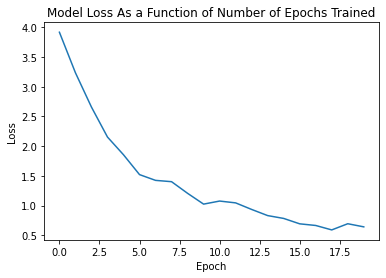

In [23]:
plot_model_loss(history)

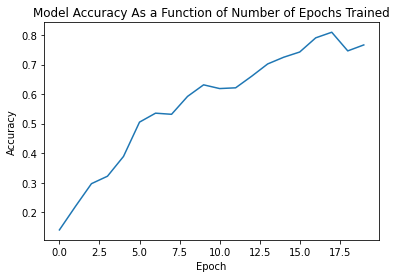

In [24]:
plot_model_accuracy(history)

In [26]:
def plot_model_accuracy(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
def plot_model_loss(history):
    """Loss Plotting Function"""
    plt.plot(history.history['loss'])
    plt.title('Model Loss As a Function of Number of Epochs Trained')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
# SET UP THE FOLD R         
# DO FEATURE SELECTION FOR THIS FOLD
def cross_fold_fs(example_test_run):
    train_these = runs != example_test_run
    test_these  = runs == example_test_run

    # an example of logical indexing
    train_patterns = patterns[train_these, :]
    train_targets = targets[train_these, :]

    test_patterns = patterns[test_these, :]
    test_targets = targets[test_these, :]

    # "feature selection" of statistically category-modulated voxels
    fs_train_patterns, fs_test_patterns = feature_selection(train_patterns,
                                                            train_targets,
                                                            test_patterns)
    
    return fs_train_patterns, fs_test_patterns

# TRAIN LINEAR CLASSIFIER
def make_train_model(nin, nout, fs_train_patterns, train_targets, my_epochs=30, my_batch=256):
    network_softmax = models.Sequential()
    network_softmax.add(layers.Dense(nout, 
                             activation='softmax',
                             kernel_regularizer=l2(0.001),
                             input_shape=(nin,)))

    network_softmax.compile(optimizer='adam', 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', 'mse'])

    history = network_softmax.fit(fs_train_patterns,
                                  train_targets,
                                  epochs=my_epochs,
                                  batch_size=my_batch,
                                  verbose=False)
    
    return network_softmax

# TEST LINEAR CLASSIFIER
def test_classifier(fs_test_patterns, n_cats, targets, network_softmax):
# Get train, test arrays for each CATEGORY
    n_test_dim, n_test_vox = fs_test_patterns.shape

    i_test_prev = 0
    test_dims = n_test_dim//n_cats
    i_test_next = test_dims*(idx_cat+1)

    test_patterns_array[idx_cat] = fs_test_patterns[i_test_prev:i_test_next, :]
    i_test_prev, i_test_next = i_test_next, test_dims*(idx_cat+1)

    # Take target array (LABELS) and build into a full matrix
    target_array = targets[idx_cat, :]
    for j in range(test_patterns_array[idx_cat].shape[0] - 1):
        target_array = np.vstack((target_array,targets[idx_cat, :]))
    test_targets_array[idx_cat] = target_array

    # Now, evaluate based on those CATEGORIES
    results = network_softmax.evaluate(test_patterns_array[idx_cat], 
                           test_targets_array[idx_cat], 
                           verbose=False)
    #test_loss, test_acc = results[0], results[1]
    return results

# Hmmm do I need to use both...?
test classifier
- using network.evaluate() method for overall performance
- using network.predict() method to get classification of individual test items

In [27]:
n_runs = 5

n_cross_folds = 12
n_cats = targets.shape[1]
nout = n_cats

test_patterns_array = [-1]*n_cats
test_targets_array = [-1]*n_cats
    
classification_array = np.zeros((n_runs, n_cross_folds, n_cats))

In [ ]:
# Prevent this from running for now
for run_num in range(n_runs):
    for n_cross in range(n_cross_folds):
        # SET UP THE FOLD R, DO FEATURE SELECTION FOR THIS FOLD
        fs_train_patterns, fs_test_patterns = cross_fold_fs(n_cross)

        # Input dimensions is the number of voxels
        nin  = fs_train_patterns.shape[1]

        # TRAIN LINEAR CLASSIFIER
        network_softmax = make_train_model(nin, nout, fs_train_patterns, train_targets)

        for idx_cat in range(n_cats):
            # TEST LINEAR CLASSIFIER
            results = test_classifier(fs_test_patterns, n_cats, targets, network_softmax)

            # SAVE CLASSIFIER PERFORMANCE
            classification_array[run_num, n_cross, idx_cat] = results[1]

# REPORT AVERAGE OF CLASSIFIERS
# SAVE AVERAGE PERFORMANCE TO ARRAY TO CALCUALTE CHANCE RANGE

In [28]:
for run_num in range(n_runs):
    for n_cross in range(n_cross_folds):
        # Get each CROSS FOLD
        fs_train_patterns, fs_test_patterns = cross_fold_fs(n_cross)

        # Input dimensions is the number of voxels
        nin  = fs_train_patterns.shape[1]
        

        network_softmax = models.Sequential()
        network_softmax.add(layers.Dense(nout, 
                                 activation='softmax',
                                 kernel_regularizer=l2(0.001),
                                 input_shape=(nin,)))

        network_softmax.compile(optimizer='adam', 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy', 'mse'])

        history = network_softmax.fit(fs_train_patterns,
                                      train_targets,
                                      epochs=my_epochs,
                                      batch_size=my_batch,
                                      verbose=False)

        for idx_cat in range(n_cats):
            # Get train, test arrays for each CATEGORY
            n_train_dim, n_train_vox = fs_train_patterns.shape
            n_test_dim, n_test_vox = fs_test_patterns.shape

            i_train_prev, i_test_prev = 0, 0
            train_dims, test_dims = n_train_dim//n_cats, n_test_dim//n_cats
            i_train_next, i_test_next = train_dims*(idx_cat+1), test_dims*(idx_cat+1)

            test_patterns_array[idx_cat] = fs_test_patterns[i_test_prev:i_test_next, :]
            i_test_prev, i_test_next = i_test_next, test_dims*(idx_cat+1)

            # Take target array (LABELS) and build into a full matrix
            target_array = targets[idx_cat, :]
            for j in range(test_patterns_array[idx_cat].shape[0] - 1):
                target_array = np.vstack((target_array,targets[idx_cat, :]))
            test_targets_array[idx_cat] = target_array
            
            # Now, evaluate based on those CATEGORIES
            results = network_softmax.evaluate(test_patterns_array[idx_cat], 
                                   test_targets_array[idx_cat], 
                                   verbose=False)
            #test_loss, test_acc = results[0], results[1]
            classification_array[run_num, n_cross, idx_cat] = results[1]

In [32]:
oaca = np.sum(classification_array)/classification_array.size
print(f"The overall average classification accuracy is {oaca:.4}%")

The overall average classification accuracy is 0.1195%


In [33]:
cat_accs = np.zeros((n_runs, n_cats))

for i in range(n_runs):
    for k in range(n_cats):
        old_sum = cat_accs[i, k]
        new_sum = np.sum(classification_array[i, :, k])
        running_sum = old_sum + new_sum
        cat_accs[i, k] = running_sum
        
cat_accs_list = []

for i in range(n_cats):
    cat_accs_list.append(np.sum(cat_accs[:, i]))
    
cat_accs_final = [acc/(classification_array.size/n_cats) for acc in cat_accs_list]

In [34]:
cat_accs_final

[0.1333333358168602,
 0.12037037176390489,
 0.10679012400408586,
 0.11250000245248278,
 0.11148148473973075,
 0.10925925963868698,
 0.11931217260037859,
 0.14328703726641834]

Are	certain	categories classified more accurately? How	much variability is there across categories	and	across	folds?

<hr>

#### function to scramble targets for permutation test

(as described in class)

what if we were to scramble the labels associated
with different brain scans (don't touch brain scans)?
e.g., on one run, voxel measures when a face is shown
would be labeled as being trials when a chair was shown,
and on another run, voxel measures when a face is shown
would be labeled as being trials when a shoe was shown
the performance for a classifier trained on that random
shuffling of labels would indicate the level of performance
you would expect for a classifier "by chance"

PERMUTATE THE LABELS

In [ ]:
# how to scramble the category labels for a permutation analysis

def scramble_targets(targets, runs):
    # there are 12 runs
    n_runs = np.max(runs).astype('int') + 1
    
    # there are 8 categories
    n_cats = targets.shape[1]
    
    # this will contain the scrambled category labels
    scram_targets = np.zeros(targets.shape)
    
    for i in range(n_runs):
        # first find the category labels just for this run
        these_targets = targets[runs==i, :].copy()
        
        # this shuffles the columns of these_targets, which preserves 
        # the block structure of the experiment
        scram_targets_this_run = these_targets[:, np.random.permutation(n_cats)]
        
        # this copies the scrambled targets for this run into the 
        # appropriate rows of the scrambled category labels matrix
        scram_targets[runs==i,:] = scram_targets_this_run

    return scram_targets

In [ ]:
n_perms = 10

for p in range(n_perms):
    # PERMUTE LABELS
    scram_targets = scramble_targets(targets, runs)
    
    # SET UP DATA STRUCTURES FOR STORAGE
    for i in range(n_iters):
        for r in range(n_runs):
            # SET UP THE FOLD R
            
            # DO FEATURE SELECTION FOR THIS FOLD
            fs_train_patterns, fs_test_patterns = feature_selection(train_patterns,
                                                        scram_train_targets,
                                                        test_patterns)
            
            # TRAIN LINEAR CLASSIFIER
            # TEST LINEAR CLASSIFIER
            # SAVE CLASSIFIER PERFORMANCE
    # REPORT AVERAGE OF CLASSIFIERS
    # SAVE AVERAGE PERFORMANCE TO ARRAY TO CALCUALTE CHANCE RANGE